In [43]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File ‘airline_passengers.csv’ already there; not retrieving.



In [44]:
import pandas as pd
import numpy as np

In [45]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [46]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [47]:
df.isna().sum()

,0
Passengers,0


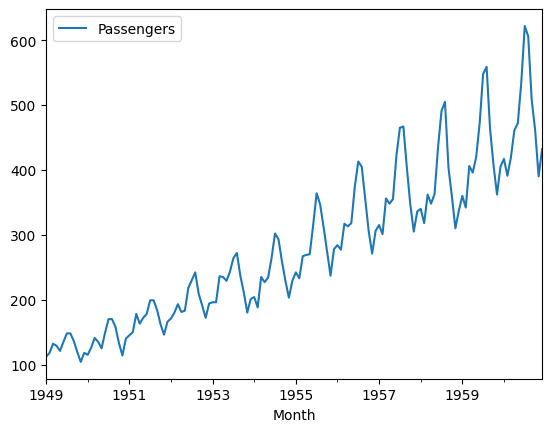

In [48]:
df.plot();

In [49]:
alpha = 0.2

In [50]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [51]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

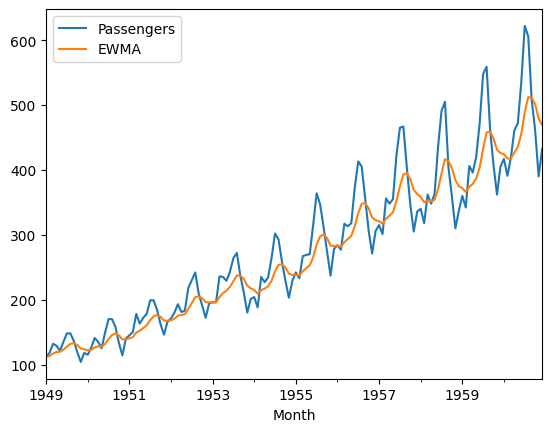

In [52]:
df.plot();

In [53]:
passengerArray = df['Passengers'].to_numpy()
manual_ewma = [passengerArray[0]]
for i in range(1,len(passengerArray)): manual_ewma.append(alpha * passengerArray[i] + (1 - alpha) * manual_ewma[-1])
df['Manual'] = manual_ewma

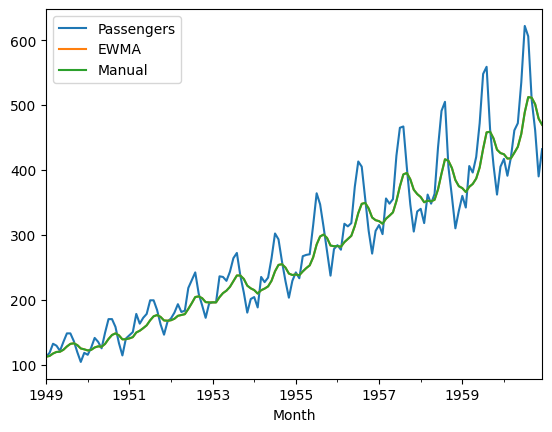

In [54]:
df.plot();

In [55]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [56]:
df.drop('Manual', axis=1, inplace=True)

In [57]:
!pip install -U statsmodels

In [58]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [59]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [60]:
# link to offset aliases docs
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [61]:
df.index.freq = 'MS'

In [62]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [63]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [64]:
res

In [65]:
res.predict(start=df.index[0], end=df.index[-1])

,0
Month,
1949-01-01,112.000000
1949-02-01,112.000000
1949-03-01,113.200000
1949-04-01,116.960000
1949-05-01,119.368000
...,...
1960-08-01,488.767616
1960-09-01,512.214093
1960-10-01,511.371274


In [66]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [67]:
np.allclose(df['SES'], res.fittedvalues)

True

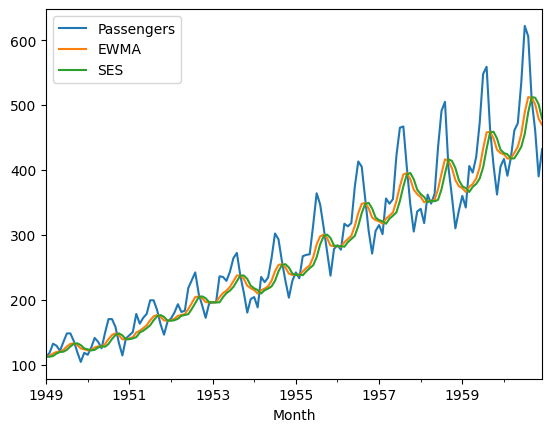

In [68]:
df.plot();

In [69]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [70]:
df['SES-1'] = df['SES'].shift(-1)

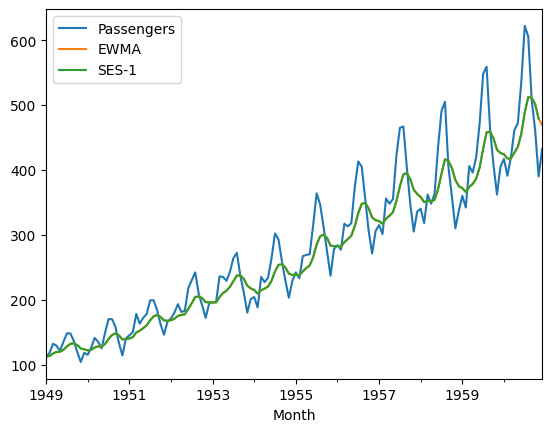

In [71]:
### No!
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [72]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [73]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic')
res = ses.fit()

In [74]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

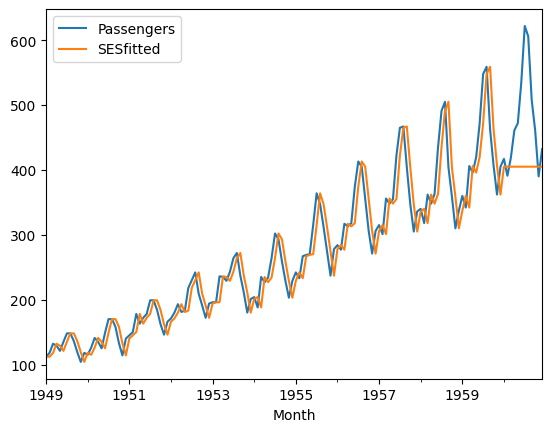

In [75]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [78]:
res.params
# since smoothing_level = 0.999999985098838 is very close to 1, the predictor is almost copying just the last value in time series as prediction

{'smoothing_level': np.float64(0.9999999850988388),
 'smoothing_trend': np.float64(nan),
 'smoothing_seasonal': np.float64(nan),
 'damping_trend': nan,
 'initial_level': np.float64(112.0),
 'initial_trend': np.float64(nan),
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [79]:
from statsmodels.tsa.holtwinters import Holt

In [80]:
holt = Holt(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [81]:
res_h = holt.fit()

In [82]:
df['Holt'] = res_h.fittedvalues

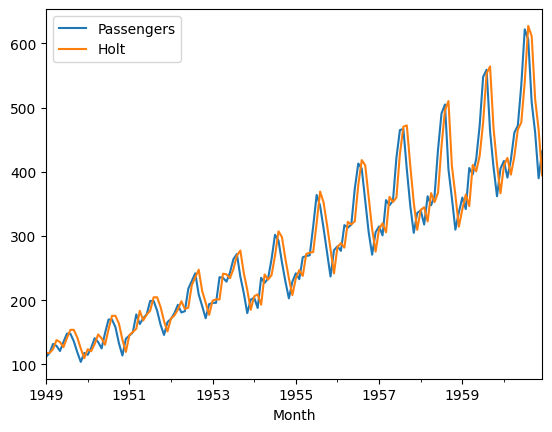

In [83]:
df[['Passengers', 'Holt']].plot();

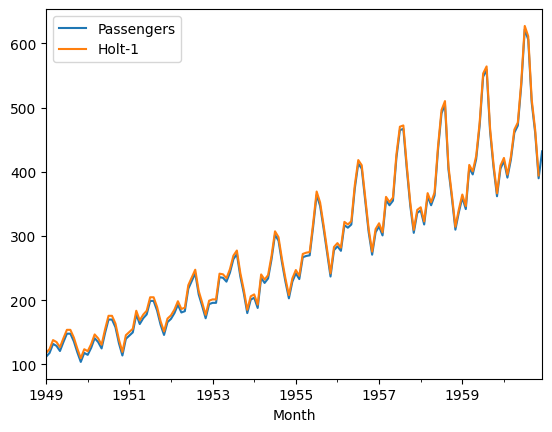

In [85]:
### No!
# Don't do this because value calculated at time t is prediction for time t + 1
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot();

In [86]:
holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [87]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

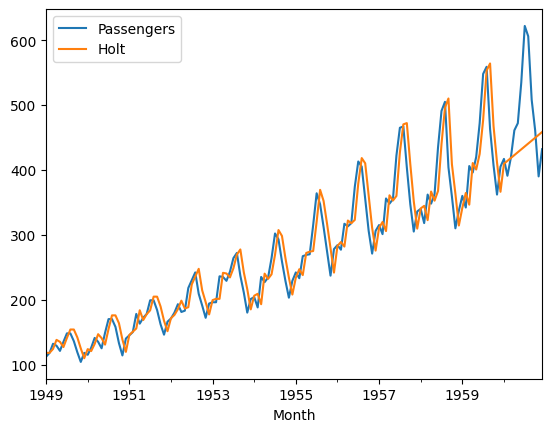

In [89]:
# This model captures TREND but NOT SEASONALITY
# We capture TREND and SEASONALITY next with a different model (HOLTWINTERS MODEL)
df[['Passengers', 'Holt']].plot();

In [90]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [91]:
# trend is additive and seasonality is also additive, seasanolity period is 12 because data is monthly
# initialization_method='legacy-heuristic' means first value (seed value of EWMA) is the first value of given time series
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [92]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

In [93]:
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

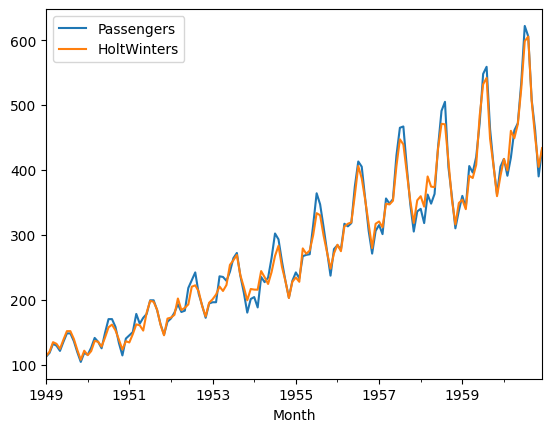

In [94]:
df[['Passengers', 'HoltWinters']].plot();

In [96]:
# root mean square error
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

In [97]:
# mean absolute error
def mae(y, t):
  return np.mean(np.abs(y - t))

In [98]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.85299095492107
Test RMSE: 15.54310494790158


In [99]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 8.892100161137758
Test MAE: 10.438211267906388


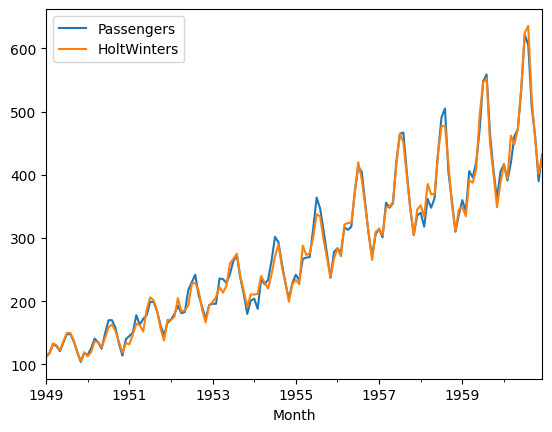

In [100]:
# trend is additive and seasonality is multiplicative, seasanolity period is 12 because data is monthly
# initialization_method='legacy-heuristic' means first value (seed value of EWMA) is the first value of given time series
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [101]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 10.153934838981055
Test RMSE: 16.535217423553572


In [102]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.5520521938866265
Test MAE: 10.683343722717524


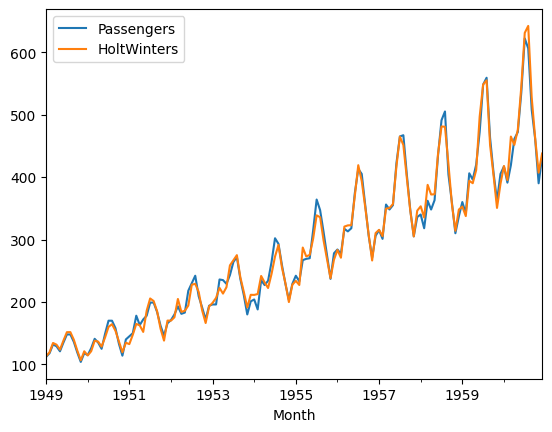

In [103]:
# trend is multiplicative (upward curving trend) and seasonality is also multiplicative(amplitude is increasing with time),
# seasanolity period is 12 because data is monthly
# initialization_method='legacy-heuristic' means first value (seed value of EWMA) is the first value of given time series
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [104]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.887178133763879
Test RMSE: 19.101890824949145


In [105]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.408709641654618
Test MAE: 13.450244770175496
